In [1]:
import pandas, numpy

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4)})

# 0. user-defined variables

In [2]:
input_file = '/Users/adrian/gd15/hi/research/plefa/data/outliers/ALL Results.xlsx'
log_file = '/Users/adrian/gd15/hi/research/plefa/results/outliers/log.txt'
output_file = ''

In [3]:
log = open(log_file, 'w')

In [4]:
epsilon = 2.0666494118981427e-05/2
print(epsilon)
print(numpy.log2(epsilon))

1.0333247059490713e-05
-16.562346804887277


# 1. read data

In [5]:
df = pandas.read_excel(input_file)
print(df.shape)
df.head()

(162, 42)


,Group,DAY,EPA,18-HEPE,5-HEPE,15-HEPE,12-HEPE,DHA,17-HDHA,10-HDHA,...,6-trans-LTB4,"6t,12epi-LTB4",12-KETE,15-KETE,5-KETE,11(12)EET,13-HoDE,13-HoTrE,9-HoDE,9-HoTrE
0,Control,D00,0.007358,0.002937,0.001037,0.000891,0.002772,0.006285,0.001012,0.002821,...,0.000511,0.000444,0.003095,0.004943,0.007140,0.009245,0.002516,0.004890,0.014699,0.020712
1,Control,D00,0.025620,0.005006,0.001309,0.000766,0.001021,0.009492,0.000192,0.001597,...,0.000406,0.000160,0.006190,0.008074,0.009528,0.010066,0.000726,0.000628,0.009040,0.011891
2,Control,D00,0.011362,0.007127,0.002218,0.000477,0.013195,0.009212,0.000773,0.004575,...,0.001826,0.002195,0.005997,0.009762,0.016034,0.005500,0.006931,0.010644,0.039511,0.040952
3,Control,D00,0.007132,0.065238,0.020250,0.012612,0.020570,0.004484,0.009446,0.053498,...,0.020726,0.021358,0.009305,0.028514,0.040523,0.011607,0.076879,0.151278,0.409499,0.550954
4,K-K,D07,0.039052,0.073206,0.017588,0.072260,0.200565,0.101139,0.016898,0.099561,...,0.003958,0.003893,0.067953,0.019411,0.019748,0.037816,0.028164,0.078593,0.069416,0.101605


In [6]:
# define working data
treatments = list(set(df['Group'].values))
excluding_treatments = ['Blue (CS-STSG)', 'Blue (K-STSG)', 'Control']
for excluding in excluding_treatments:
    treatments.remove(excluding)

contrasts = [[treatments[0], treatments[2]], [treatments[1], treatments[3]]]

days = list(set(df['DAY'].values))
days.remove('D00')

metabolites = list(df.columns.values[2:])

print(days)
print(contrasts)

['D28', 'D07', 'D21', 'D60', 'D14']
[['Primatrix', 'K-K'], ['CS-STGS', 'K-STSG']]


# 2. boxplots and statistical test

In [7]:
a =  numpy.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
a[(a > 3) & (a < 7)]
a.shape

(10,)

In [8]:
def outlier_remover(values):
    
    q1 = numpy.percentile(values, 25)
    q3 = numpy.percentile(values, 75)
    iqr = q3 - q1
    
    lowerb = q1 - 1.5*iqr
    upperb = q3 + 1.5*iqr
    
    if iqr > 0:
        wo = values[values < upperb]
    else:
        wo = values
    
    if values.shape != wo.shape:
        log.write('REMOVING OUTLIERS | {} \t {}\n'.format(values.shape, values))
        log.write('REMOVING OUTLIERS | q1, q3, iqr, lb, up: {} {} {} {} {}\n'.format(q1, q3, iqr, lowerb, upperb))
        log.write('REMOVING OUTLIERS | {} \t {}\n'.format(wo.shape, wo))
        log.write('REMOVING OUTLIERS\n')
    
    return wo

In [9]:
all_values = []

for contrast in contrasts:
    for day in days:
        for metabolite in metabolites:
            condition1 = contrast[0]
            condition2 = contrast[1]
            
            log.write('{} \t {} \t {} \t {} \n'.format(condition1, condition2, day, metabolite))
            
            # get values
            values1 = df[(df['DAY'] == day) & ((df['Group'] == condition1))][metabolite].values
            values2 = df[(df['DAY'] == day) & ((df['Group'] == condition2))][metabolite].values
            
            # format values
            formatted_values1 = []; formatted_values2 = []
            for element in values1:
                if numpy.isnan(element) == False:
                    formatted_values1.append(float(element))
            for element in values2:
                if numpy.isnan(element) == False:
                    formatted_values2.append(float(element))
            
            for element in list(formatted_values1):
                all_values.append(element)
            for element in list(formatted_values2):
                all_values.append(element)
                
            testing_values1 = numpy.log2(numpy.array(formatted_values1) + epsilon)
            testing_values2 = numpy.log2(numpy.array(formatted_values2) + epsilon)
            
            log.write('{}\n'.format(formatted_values1))
            log.write('{}\n'.format(formatted_values2))
            log.write('\n')
            log.write('{}\n'.format(testing_values1))
            log.write('{}\n'.format(testing_values2))
            
            if len(testing_values1) < 6:
                warning = '\t WARNING: Metabolite {} in day {} in condition {} has {} values measured.\n'.format(metabolite, day, condition1, len(testing_values1))
                log.write(warning)
            if len(testing_values2) < 6:
                warning = '\t WARNING: Metabolite {} in day {} in condition {} has {} values measured.\n'.format(metabolite, day, condition2, len(testing_values2))
                log.write(warning)
            
            #
            # detect outliers
            #
            values1_wo = outlier_remover(testing_values1)
            values2_wo = outlier_remover(testing_values2)
            
            # run boxplots
            
            # run tests
            
            log.write('\n')

In [10]:
for element in all_values:
    if type(element) != float:
        print(type(element), element)

In [11]:
all_values.sort()

In [12]:
print(all_values[:300])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


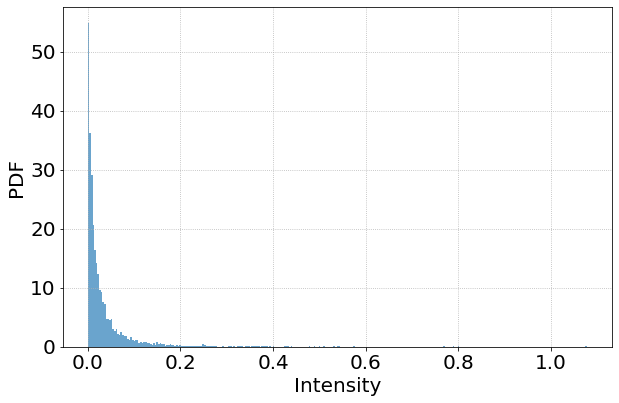

In [13]:
matplotlib.pyplot.figure(figsize=(9, 6))
tempo = matplotlib.pyplot.hist(all_values, bins='auto', density=True, alpha=2/3)
matplotlib.pyplot.xlabel('Intensity')
matplotlib.pyplot.ylabel('PDF')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()

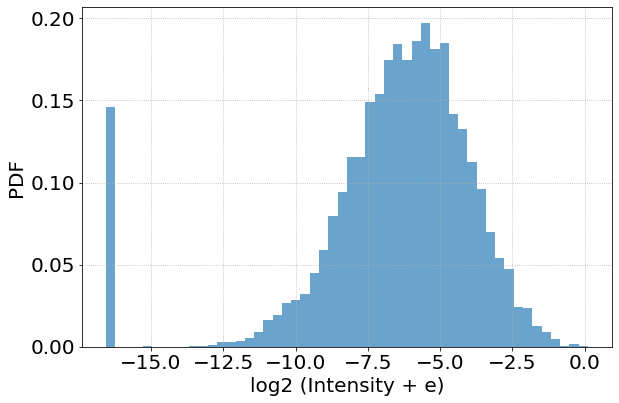

In [14]:
matplotlib.pyplot.figure(figsize=(9, 6))
tempo = matplotlib.pyplot.hist(numpy.log2(numpy.array(all_values)+epsilon), bins='auto', density=True, alpha=2/3)
matplotlib.pyplot.xlabel('log2 (Intensity + e)')
matplotlib.pyplot.ylabel('PDF')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()

In [15]:
log.close()